In [1]:
import numpy as np
import awkward
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')
import numpy as np
import scipy.optimize as opt
import sys, os, random, gzip
import tensorflow as tf
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
import pandas as pd

Using TensorFlow backend.


In [2]:
##========================================================data by pythia
_e,_pt,_eta,_phi,_logpt,_loge=0,1,2,3,4,5
def deltaPhi(phi1,phi2):
    x = phi1-phi2
    while x>= np.pi: x -= np.pi*2.
    while x< -np.pi: x += np.pi*2.
    return x

def deltaR(eta1,phi1,eta2,phi2):
    return (deltaPhi(phi1,phi2)**2+(eta1-eta2)**2)**0.5

def find_main_axis(clist):
    def fcn(p):
        dir_x,dir_y = np.cos(p[0]),np.sin(p[0])
        v = clist[(clist[:,_eta]**2+clist[:,_phi]**2)**0.5>1E-5]
        cosang = np.abs(dir_x*v[:,_eta]+dir_y*v[:,_phi])/(v[:,_eta]**2+v[:,_phi]**2)**0.5
        proj = (v[:,_pt]*cosang).sum()
        return -proj
    r = opt.minimize(fcn,[0.])
    if r.success: return r.x[0]
    else: return None
def parse_jet_data(fin):
    
    
#     if '<jet_data>' not in fin.readline().decode():
#         print(">>> ERROR: invalid input", flush=True)
#         sys.exit(0)
    
    data = {}
#     features_list = {}
    fin.readline().decode().split()
    buf = fin.readline().decode().split() # jet kinematics
    data['e'] = float(buf[0])
    data['pt'] = float(buf[1])
    data['eta'] = float(buf[2])
    data['phi'] = float(buf[3])
    data['nconstituents'] = int(buf[4])
    fin.readline().decode().split()
    clist, mask, features, points = [],np.zeros((100,1)), np.zeros((100,5)), np.zeros((100,2)) # prepare constituents list
    if (data['nconstituents']<=100):
        for i in range(data['nconstituents']):  ##particlenet need to be 100
            #         _pt,_eta,_phi=1,2,3 #myfile use pt in index 1, eta->2,phi->3
            var = [float(s) for s in fin.readline().decode().split()] # index, type(0:gen/1:track/2:Ecal/3:Hcal), pid, charge, pt, eta, phi, vx, vy, vz
            var_logpt = np.log(var[_pt])
            var_loge = np.log(var[_e])
            var[_eta] = var[_eta]-data['eta']
            var[_phi] = deltaPhi(var[_phi],data['phi'])
            mask[i]=np.array([var_logpt])
            features[i]=np.array([var_logpt,var_loge,var[_eta],var[_phi], var[_pt]/data['pt']] ) #last one is my argue
            points[i]=np.array([var[_eta],var[_phi] ])#, var[_pt]/data['pt']])
    else:
        for i in range(data['nconstituents']):
            fin.readline().decode().split()
       

#     clist = np.array(clist)
#     features_list['mask']=np.array(mask)
#     features_list['points']=np.array(points)
#     features_list['features']=np.array(features)
#     dir = find_main_axis(clist) ##rotation
#     if dir!=None:
#         dir = -dir # rotation everything to x-axis
#         clist[:,_eta], clist[:,_phi] = np.cos(dir)*clist[:,_eta]-np.sin(dir)*clist[:,_phi], np.sin(dir)*clist[:,_eta]+np.cos(dir)*clist[:,_phi]

    
    return mask.tolist(), features.tolist(), points.tolist()
def prepare(n,fin):
    fin=gzip.open(fin)
    features_list = {}
    mask, features, points = [],[],[]
    for i in range(n):
        a, b, c = parse_jet_data(fin)
        mask.append(a)
        features.append(b)
        points.append(c)

    features_list['mask']=mask
    features_list['points']=points
    features_list['features']=features
    return features_list
    
def separatedata(features_list,y,rateval,ratetest):
    features_train, features_test, features_val={},{},{}
    from sklearn.model_selection import train_test_split
    mask = features_list["mask"]
    features = features_list["features"]
    points = features_list["points"]
    X_ind = [i for i in range(len(y))]
    X_train, X_ind, y_train, y_ind = train_test_split(X_ind, y, test_size=rateval+ratetest)
    N=int(len(X_ind)*rateval/(rateval+ratetest))
    X_val, X_test = X_ind[:N], X_ind[N:]
    y_val, y_test = y_ind[:N], y_ind[N:]
    features_train['mask']=np.array([mask[i] for i in X_train])
    features_train['features']=np.array([features[i] for i in X_train])
    features_train['points']=np.array([points[i] for i in X_train])
    
    features_test['mask']=np.array([mask[i] for i in X_test])
    features_test['features']=np.array([features[i] for i in X_test])
    features_test['points']=np.array([points[i] for i in X_test])
    
    features_val['mask']=np.array([mask[i] for i in X_val])
    features_val['features']=np.array([features[i] for i in X_val])
    features_val['points']=np.array([points[i] for i in X_val])
    
    return features_train, features_val, features_test,np.array(y_train), np.array(y_val), np.array(y_test) 
def merging(gg,qq):
    total={}
    total['mask']=gg["mask"]+qq["mask"]
    total['features']=gg["features"]+qq["features"]
    total['points']=gg['points']+qq['points']
    return total
def input_trans( X_test, y_test):
    features_test = {}
    
    features_test['mask']=np.array([i for i in X_test["mask"]])
    features_test['features']=np.array([i for i in X_test["features"]])
    features_test['points']=np.array([i for i in X_test["points"]])
    return features_test, np.array(y_test) 

In [14]:
X_test['points'].shape

(10000, 100, 3)

In [20]:
eventg, eventq = './myeventsgg.txt.gz', './myeventsqq.txt.gz'
n=5000
gg = prepare(n,eventg)
qq = prepare(n,eventq)
y=[[0,1] for i in range(len(gg['mask']))]+[[1,0] for i in range(len(qq['mask']))] ##?????????????????
total = merging(gg,qq)

In [21]:
X_test, y_test = input_trans(total,y)

In [3]:
eventg, eventq = './myeventsgg2.txt.gz', './myeventsqq2.txt.gz'
n=50000
gg = prepare(n,eventg)
n=24000
qq1 = prepare(n,eventq)
eventq = './myeventsqq1.txt.gz'
n=26000
qq2 = prepare(n,eventq)
qq = merging(qq2,qq1)

In [4]:

y=[[0,1] for i in range(len(gg['mask']))]+[[1,0] for i in range(len(qq['mask']))] ##?????????????????
total = merging(gg,qq)

del gg, qq, eventg, eventq, qq1, qq2

In [5]:
# del gg, qq, eventg, eventq
X_train, X_val, X_test, y_train, y_val, y_test = separatedata(total,y,0.3,0.1)

In [6]:


import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite

In [7]:
##self

model_type = 'particle_net'
input_shapes={'points': (100, 2), 'features': (100, 5), 'mask': (100, 1)}
num_classes = 2
model = get_particle_net(num_classes, input_shapes)

In [8]:
# Training parameters
batch_size = 64 if 'lite' in model_type else 64
epochs = 25

In [9]:
# def lr_schedule(epoch):
#     lr = 1e-3
#     if epoch > 10:
#         lr *= 0.1
#     elif epoch > 20:
#         lr *= 0.01
#     logging.info('Learning rate: %f'%lr)
#     return lr
def lr_schedule(epoch):
    lr = 2e-2
    if epoch > 4:
        lr *= 1/3
    if epoch > 9:
        lr *= 1/3
    if epoch > 14:
        lr *= 1/3
    if epoch > 19:
        lr *= 1/3
    logging.info('Learning rate: %f'%lr)
    return lr

In [8]:
if 'lite' in model_type:
    model = get_particle_net_lite(num_classes, input_shapes)
else:
    model = get_particle_net(num_classes, input_shapes)

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2020-03-31 13:48:08,481] INFO: Learning rate: 0.020000


Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
features (InputLayer)           [(None, 100, 5)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(None, 100, 1, 5)]  0           features[0][0]                   
__________________________________________________________________________________________________
mask (InputLayer)               [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
ParticleNet_fts_bn (BatchNormal (None, 100, 1, 5)    20          tf_op_layer_ExpandDims[0][0]     
________________________________________________________________________________________

In [11]:
# load model
model.load_weights('./myplotdata/5/my_ParticleNet.h5')

ValueError: Shapes (5,) and (4,) are incompatible

In [11]:
# Prepare model model saving directory.
import os
save_dir = './model_checkpoints'
model_name = '%s_model.test.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
csv_logger = keras.callbacks.CSVLogger('./myparticlenet_training_log.csv')
earlystop = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=0,
                            patience=50,
                            verbose=1,
                            mode='min', baseline=None,
                            restore_best_weights=True)
# callbacks = [checkpoint, lr_scheduler, progress_bar]
callbacks = [checkpoint, lr_scheduler, csv_logger, progress_bar, earlystop ]
### Add checkpoints
##########################################################################################################
# check_list=[]
# checkpoint = tf.keras.callbacks.ModelCheckpoint (monitor='val_loss',
#                              filepath='./mymodel.h5',
#                              save_best_only=True,
#                              verbose=1)
# earlystop = tf.keras.callbacks.EarlyStopping(
#                             monitor='val_loss',
#                             min_delta=0,
#                             patience=50,
#                             verbose=1,
#                             mode='min', baseline=None,
#                             restore_best_weights=True)

# csv_logger = tf.keras.callbacks.CSVLogger('./training_log.csv')
# check_list.append(checkpoint)
# check_list.append(earlystop)
# check_list.append(csv_logger)
##########################################################################################################

In [12]:
# train_dataset.shuffle()
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs, # --- train only for 1 epoch here for demonstration ---
          validation_data=(X_val, y_val),
          shuffle=True ,
          callbacks=callbacks)
model.evaluate(X_test,  y_test, verbose=2)

[2020-03-31 13:48:10,696] INFO: Learning rate: 0.020000


Train on 60000 samples, validate on 30000 samples
Epoch 1/25
Epoch 1/25
59968/60000 [============================>.] - ETA: 0s - loss: 0.4939 - accuracy: 0.7771

[2020-03-31 13:50:22,364] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 132s 2ms/sample - loss: 0.4937 - accuracy: 0.7771 - val_loss: 0.4553 - val_accuracy: 0.7877


[2020-03-31 13:50:22,548] INFO: Learning rate: 0.020000


Epoch 2/25
Epoch 2/25
12288/60000 [=====>........................] - ETA: 1:15 - loss: 0.4698 - accuracy: 0.7853

[2020-03-31 13:50:42,060] WARNING: Can save best model only with val_acc available, skipping.


KeyError: 'val_accuracy'

In [14]:
model.save('./my_ParticleNet.h5')

In [15]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pickle

The area under the curves are:
AUC:0.895958760


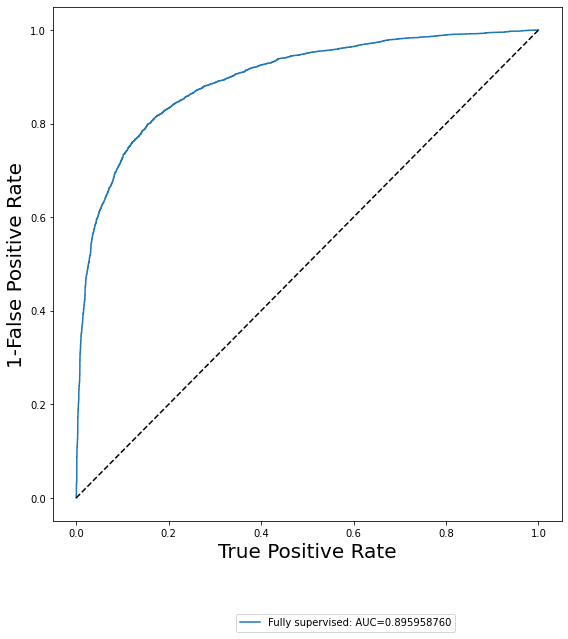

In [22]:
# y_test=[i[1] for i in testpojen_datay]
y_score=model.predict(X_test)[:,0]
test=[i[1] for i in y_test]
fpr , tpr , thresholds = roc_curve ( test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)

plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.9f}'.format(roc_auc))
plt.ylabel('1-False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("./Myneighnorhood_Particlenet_roc.png")
np.save("./myfpr",fpr)
np.save("./mytpr",tpr)
#plt.close()

# plt.subplot(2,1,2)
# LOSS = pd.read_csv('./training_log.csv')
# plt.plot(LOSS["loss"], label='loss',c='blue')
# plt.plot(LOSS["val_loss"], label='val_loss',c='red')
# plt.ylabel('loss',fontsize=20)
# plt.xlabel('epoch',fontsize=20)
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
# plt.tight_layout()

#plt.savefig("./plot_3.png")
#plt.close()
plt.show()

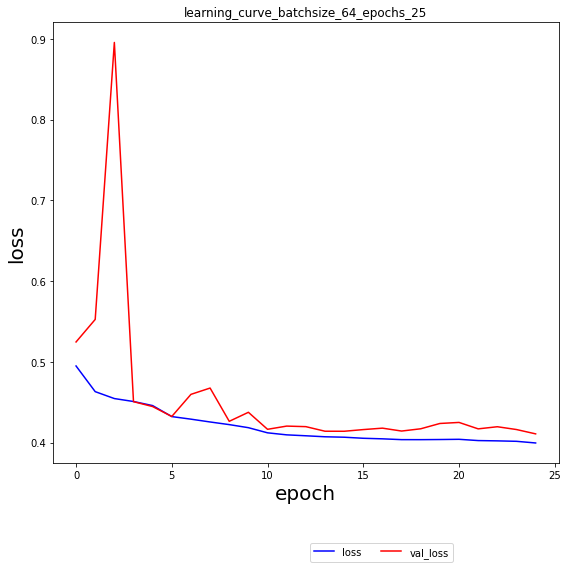

In [17]:
plt.figure(figsize=(8,8))
LOSS = pd.read_csv('./myparticlenet_training_log.csv')
plt.title("learning_curve_batchsize_"+str(batch_size)+"_epochs_"+str(epochs))
plt.plot(LOSS["loss"], label='loss',c='blue')
plt.plot(LOSS["val_loss"], label='val_loss',c='red')
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("./myloss.png")
#plt.savefig("./plot_3.png")
#plt.close()
plt.show()

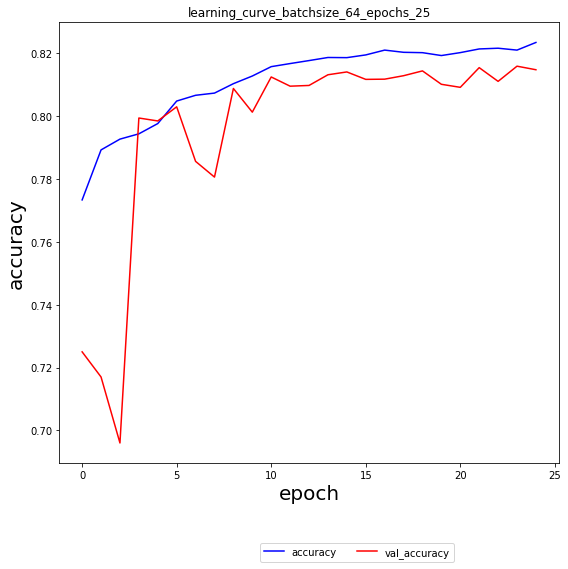

In [18]:
plt.figure(figsize=(8,8))
LOSS = pd.read_csv('./myparticlenet_training_log.csv')
plt.title("learning_curve_batchsize_"+str(batch_size)+"_epochs_"+str(epochs))
plt.plot(LOSS["accuracy"], label='accuracy',c='blue')
plt.plot(LOSS["val_accuracy"], label='val_accuracy',c='red')
plt.ylabel('accuracy',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("./myaccuracy.png")
#plt.savefig("./plot_3.png")
#plt.close()
plt.show()

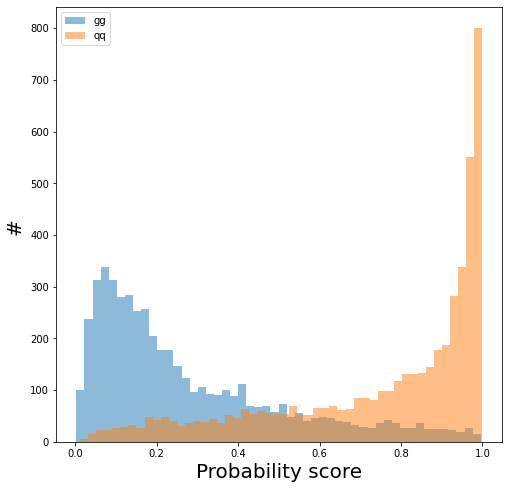

In [19]:
plt.figure(figsize=(8,8))
x=[y_score[i] for i in range(len(y_score)) if y_test[i][1]!=0 ]
y=[y_score[i] for i in range(len(y_score)) if y_test[i][1]!=1 ]
plt.hist(x, label='gg',bins=50,alpha=0.5)
plt.hist(y, label='qq',bins=50,alpha=0.5)
plt.ylabel('# ',fontsize=20)
plt.xlabel('Probability score',fontsize=20)
plt.legend()
plt.savefig("./Myneighnorhood_Particlenet_Prob.png")
np.save("./mygg",x)
np.save("./myqq",y)

In [ ]:
plt.yscale('log', nonposy='clip')

In [24]:
y_score

array([0.21931766, 0.96364534, 0.8939969 , 0.09990129, 0.06939647,
       0.04900515, 0.98152024, 0.9204125 , 0.9465758 , 0.94964224,
       0.61055213, 0.57194173, 0.02314579, 0.04739726, 0.23808876,
       0.14983001, 0.9025424 , 0.01275694, 0.51111346, 0.93463165,
       0.02785413, 0.37882042, 0.9670001 , 0.29102176, 0.08049845,
       0.01429336, 0.7560763 , 0.77384233, 0.80082667, 0.8552067 ,
       0.36729923, 0.11562628, 0.05875725, 0.04664522, 0.03622217,
       0.12828244, 0.79632866, 0.99083763, 0.07970317, 0.9330651 ,
       0.9407188 , 0.9125146 , 0.25247505, 0.13906835, 0.87527287,
       0.8372445 , 0.8951125 , 0.7650561 , 0.9906917 , 0.36150673,
       0.9080021 , 0.9908448 , 0.9512676 , 0.24333423, 0.08487101,
       0.4466815 , 0.8155141 , 0.97871304, 0.92009974, 0.02287935,
       0.98741466, 0.05914987, 0.14716144, 0.7590603 , 0.91988534,
       0.52909285, 0.5977842 , 0.61513436, 0.873578  , 0.07789466,
       0.02048822, 0.19489712, 0.14748287, 0.7528993 , 0.00665

In [14]:
from scipy.interpolate import interp1d

In [6]:

a=tf.range(0,10000)
a= tf.reshape(a, (100,100,1))
# shapec = tf.constant(a.get_shape()).get_shape()[-1]
a = tf.concat([a,a], 2)
a = tf.reshape(a, (20000,))
b = points[:,:,2]
c = tf.transpose(points[:,:,2], perm= (1, 0))

if points.shape[0] is not None:
    testc = tf.zeros((points.get_shape[0].shape[0],1,100)) +1
    testb = tf.transpose(testc, perm=(0, 2, 1))
    
    c = tf.reshape(c*testc, (points.get_shape[0],100,100,1))
    b = tf.reshape(b*testb, (points.get_shape[0],100,100,1))
    W = tf.concat([c, b],  tf.constant(c.get_shape()).get_shape()[-1] -1 )
#     W = tf.reshape(W, (points.get_shape[0], 20000,))
#     a = tf.reshape(a, (points.get_shape[0] ,20000,))
    W = tf.math.reduce_max(W, axis= tf.constant(W.get_shape()).get_shape()[-1] -1)
#     W = tf.reshape(W, (points.get_shape[0],100,100,1))
    # tf.print(c*testc)
a=tf.range(0,10000)
a= tf.reshape(a, (100,100,1))
# shapec = tf.constant(a.get_shape()).get_shape()[-1]
a = tf.concat([a,a], 2)
a = tf.reshape(a, (20000,))
b = tf.random.normal((100,1))
c = tf.transpose(tf.random.normal((100,1)), perm= (1, 0))
testc = tf.zeros((100,1)) +1
testb = tf.transpose(testc, perm=(1, 0))+1
c = tf.reshape(c*testc, (100,100,1))
b = tf.reshape(b*testb, (100,100,1))
W = tf.concat([c, b],  tf.constant(c.get_shape()).get_shape()[-1] -1 )
W = tf.reshape(W, (20000,))
W = tf.math.segment_max(W,a)
W = tf.reshape(W, (100,100,1))
# tf.print(c*testc)


NameError: name 'points' is not defined

In [13]:
from mygraph_function import map_index, map_matrix_2d

In [15]:
a = tf.constant([[-11,0.1,1/64],[-10.1,0.34,1/32],[-5.2,0.2,10]])
x = a
ind = map_index(x, dtype = tf.int32)
a = map_matrix_2d(x, ind )
sess = tf.Session()
print(sess.run(a))
sess.close()

AttributeError: module 'tensorflow' has no attribute 'Session'